# Preprocesamiento

##### Paquetes

In [1]:
install.packages('stepR')

Installing package into ‘/home/max/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [2]:
require(stepR)

Loading required package: stepR

Successfully loaded stepR package version 2.1-3.
Several new functions are added in version 2.0-0. Some older functions are deprecated (still working) and may be defunct in a later version. Please read the documentation for more details.



**Cargando los datos**

In [3]:
datos = read.csv("datos.csv")
head(datos)

,timestamp,value
,<chr>,<dbl>
1,2014-04-01 00:00:00,19.76125
2,2014-04-01 00:05:00,20.50083
3,2014-04-01 00:10:00,19.96164
4,2014-04-01 00:15:00,21.49027
5,2014-04-01 00:20:00,20.18774
6,2014-04-01 00:25:00,19.92313


**Objetivo:** Definir intervalos que contengan el patrón regular.

In [4]:
#Número de escalones
nc = 35

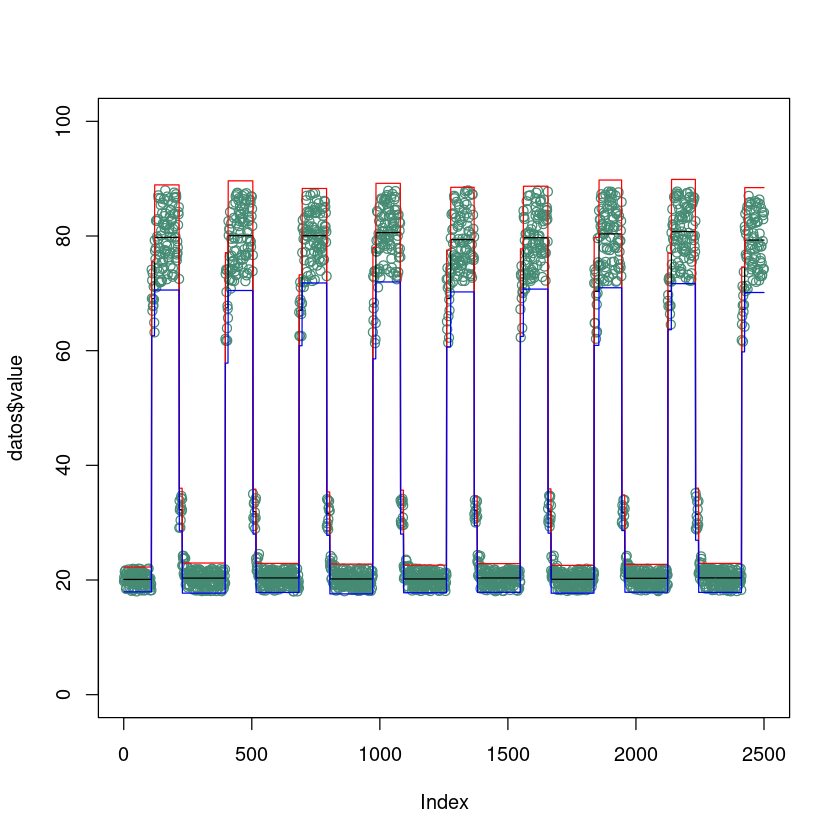

In [5]:
#Calculando el modelo
modelo = steppath(datos$value)

#Niveles ajustados
fitg <- modelo[[nc]]

#Calculo de la volatilidad
r = diff(c(0,fitg$rightEnd))
media = unlist(sapply(1:nc, function(i){rep(fitg$value[i],r[i])}))
desv = unlist(sapply(1:nc, function(i){
                  ind = fitg$leftEnd[i]:fitg$rightEnd[i]
                  rep(sqrt(var(datos$value[ind])),r[i])
            }))
liminf = media - 1.96*desv
limsup = media + 1.96*desv

#Gráfica
plot(datos$value, type = "p", col = "aquamarine4", ylim = c(0,100))
lines(media, type = "l", col = "black")
lines(limsup, type = "l", col = "red")
lines(liminf, type = "l", col = "blue")

**¿Cuántos escalones son necesarios?**

Con **18** segmentos se explica suficiente variabilidad.

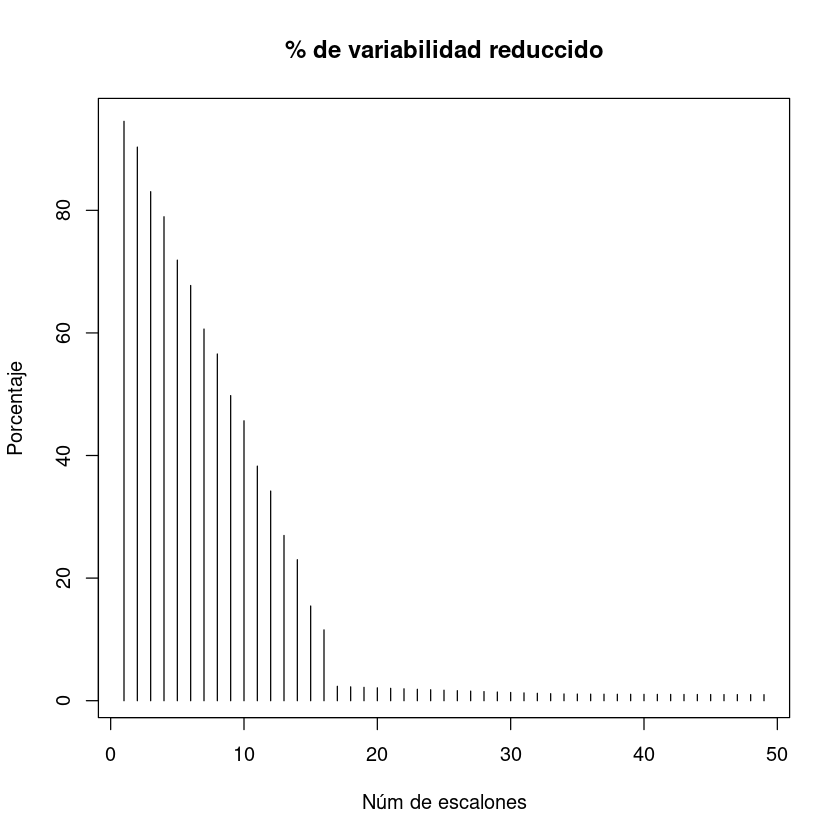

In [6]:
varianzas = sapply(2:50, function(i){
  fitg <- modelo[[i]]
  var(resid(fitg, datos$value))
})
varianza = var(datos$value)
plot(100*(varianzas/varianza), type =  "h",
 main = "% de variabilidad reduccido",
 ylab = "Porcentaje",
 xlab = "Núm de escalones")

Con **18** segmentos se obtiene poca ***cobertura***.

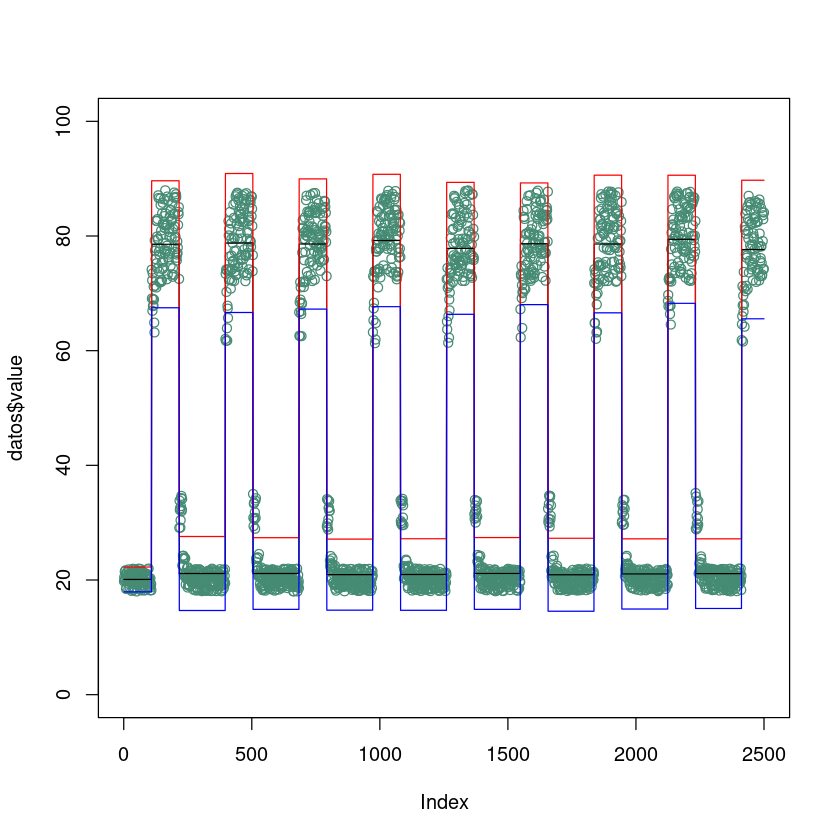

In [7]:
#Número de escalones
nc = 18

#Niveles ajustados
fitg <- modelo[[nc]]

#Calculo de la volatilidad
r = diff(c(0,fitg$rightEnd))
media = unlist(sapply(1:nc, function(i){rep(fitg$value[i],r[i])}))
desv = unlist(sapply(1:nc, function(i){
                  ind = fitg$leftEnd[i]:fitg$rightEnd[i]
                  rep(sqrt(var(datos$value[ind])),r[i])
            }))
liminf = media - 1.96*desv
limsup = media + 1.96*desv

#Gráfica
plot(datos$value, type = "p", col = "aquamarine4", ylim = c(0,100))
lines(media, type = "l", col = "black")
lines(limsup, type = "l", col = "red")
lines(liminf, type = "l", col = "blue")


Con **35** segmentos se obtiene buena ***cobertura***.

[1] 0.9776 0.9808 0.9824 0.9836 0.9840 0.9836 0.9824 0.9820 0.9812 0.9812
[11] 0.9808

[1] 5

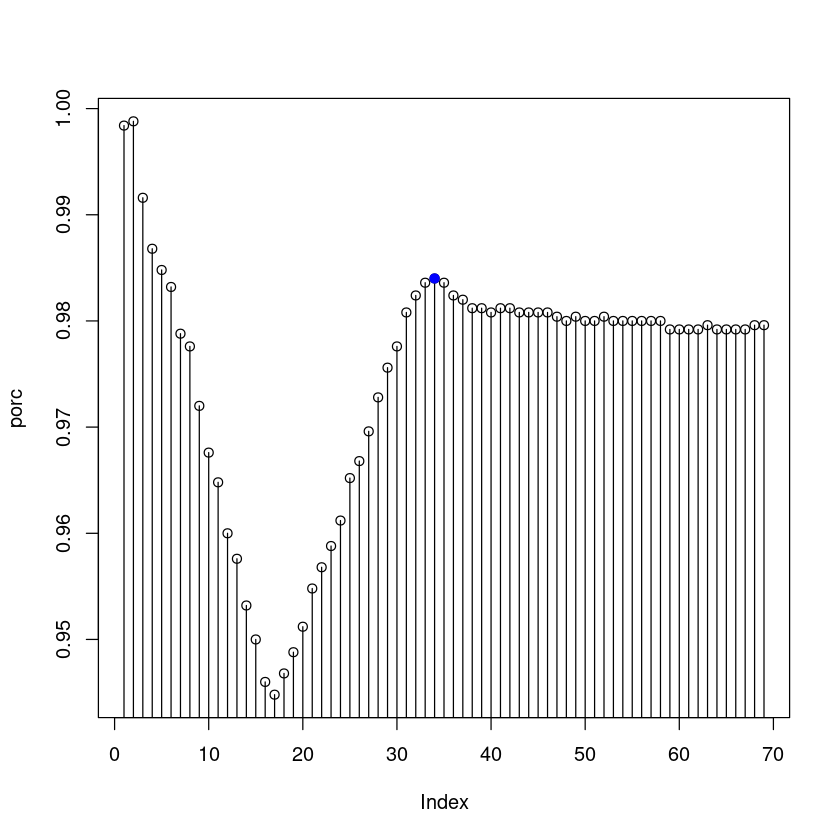

In [8]:
porc = sapply(2:70,function(nc){
        fitg <- modelo[[nc]]
        r = diff(c(0,fitg$rightEnd))
        media = unlist(sapply(1:nc, function(i){rep(fitg$value[i],r[i])}))
        desv = unlist(sapply(1:nc, function(i){
                  ind = fitg$leftEnd[i]:fitg$rightEnd[i]
                  rep(sqrt(var(datos$value[ind])),r[i])
            }))
        liminf = media - 1.96*desv
        limsup = media + 1.96*desv
        mean((liminf <= datos$value)*(datos$value<=limsup))
          })
  
plot(porc, type = "h")
points(porc)
points(x = 34, y = porc[34], col = "blue", pch = 19)
porc[30:40]
which.max(porc[30:40])


**¿Como cubrir el 100%?**

Se redefine el intervalo al error máximo observado.

In [9]:
#Número de escalones
nc = 35

#Ajustando el intervalo
fitg <- modelo[[nc]]
r = diff(c(0,fitg$rightEnd))
media = unlist(sapply(1:nc, function(i){rep(fitg$value[i],r[i])}))
desv = unlist(sapply(1:nc, function(i){
                  ind = fitg$leftEnd[i]:fitg$rightEnd[i]
                  rep(max(abs(datos$value[ind] - media[ind])/1.96,
                          sqrt(var(datos$value[ind]))),r[i])
            }))
liminf = media - 1.96*desv
limsup = media + 1.96*desv

In [10]:
mean((liminf <= datos$value)*(datos$value<=limsup))

[1] 1

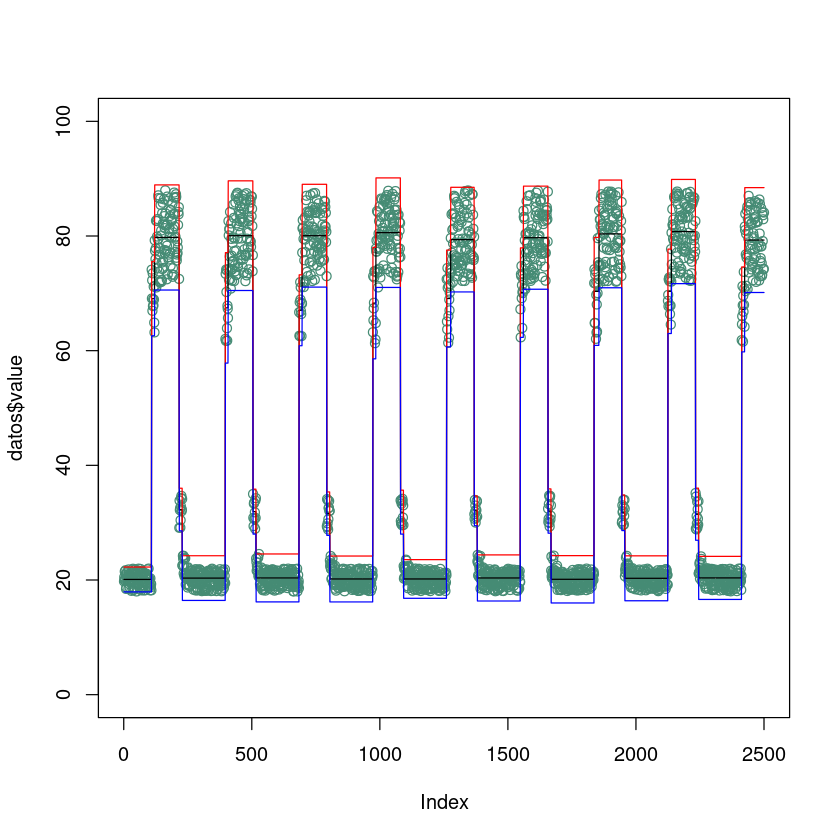

In [11]:
#Gráfica
plot(datos$value, type = "p", col = "aquamarine4", ylim = c(0,100))
lines(media, type = "l", col = "black")
lines(limsup, type = "l", col = "red")
lines(liminf, type = "l", col = "blue")

### ¿Qué atributos pueden servir para predecir $Y_t$ y $\sigma_t$?

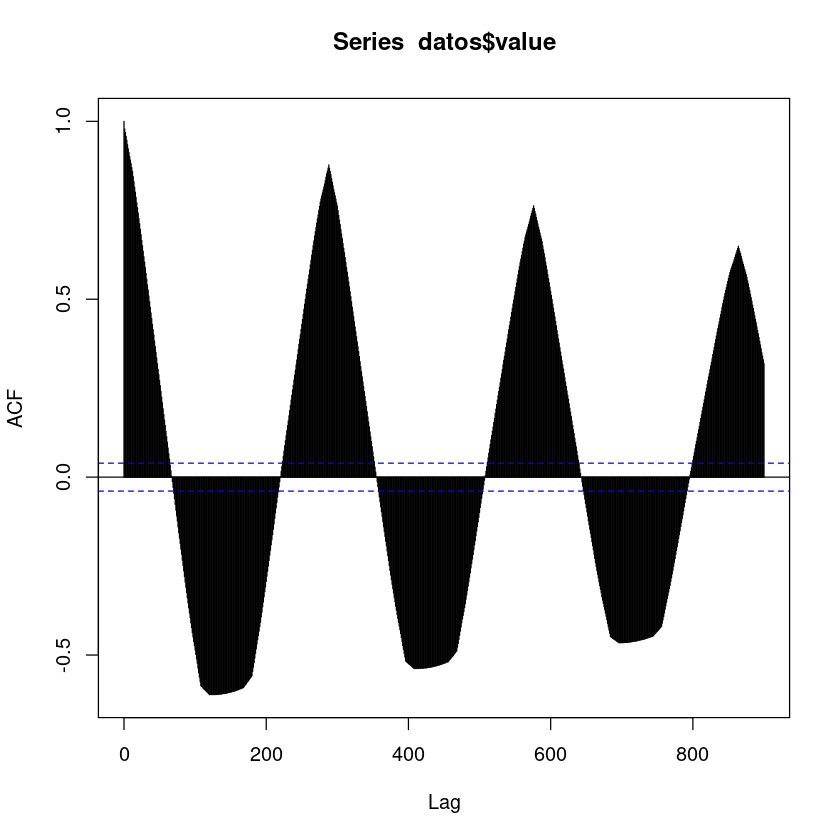

In [12]:
#autocorrelaciones
acf(datos$value, lag.max = 900)

$Y_{t-1}$ es relevante  y al restarlo $(Y_{t} - Y_{t-1})$ simplifica las autocorrelaciones.

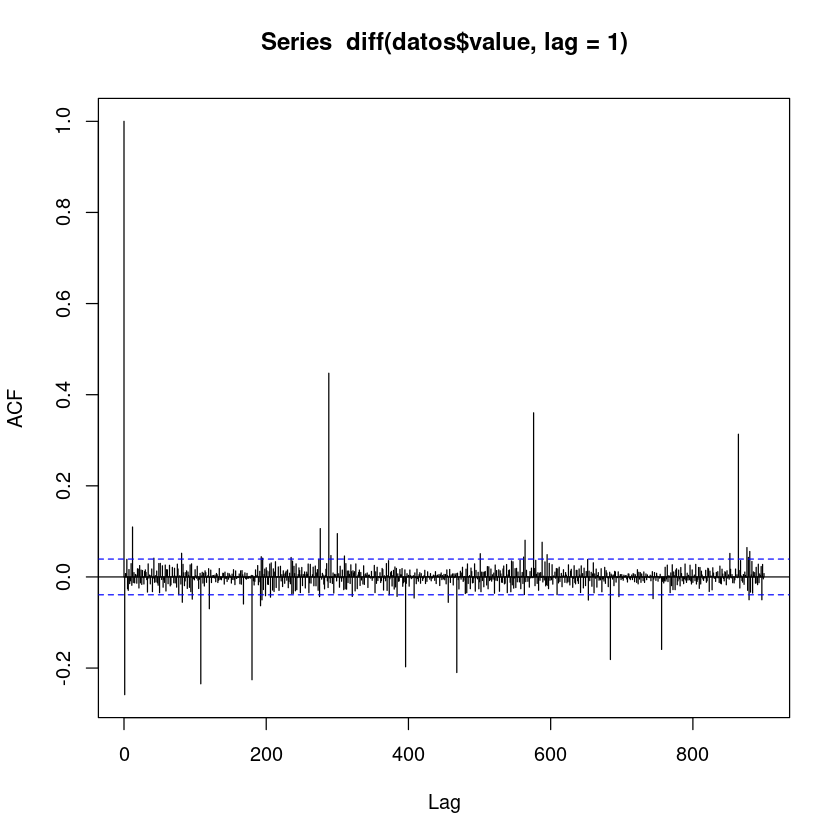

In [13]:
#autocorrelaciones
autocorr = acf(diff(datos$value, lag = 1), lag.max = 900)

In [14]:
which( abs(autocorr$acf) > 0.2)

[1]   1   2 109 181 289 469 577 865

**Los atributos seleccionados para la predicción son:**

- $Y_{t-1}$
- $Y_{t-109}$
- $Y_{t-181}$
- $Y_{t-289}$.

## Construyendo la matriz de entrenamiento.

In [21]:
Tmax = dim(datos)[1]

colnames(datos)[2] = "Y"
datos$media = media
datos$radio = desv
datos$Y1 = c(NA,datos$Y[1:(Tmax-1)])
datos$Y109 = c(rep(NA,109), datos$Y[1:(Tmax-109)])
datos$Y181 = c(rep(NA,181), datos$Y[1:(Tmax-181)])
datos$Y289 = c(rep(NA,289), datos$Y[1:(Tmax-289)])
head(datos)


,timestamp,Y,media,radio,Y1,Y109,Y181,Y289
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2014-04-01 00:00:00,19.76125,20.09437,1.105089,NA,NA,NA,NA
2,2014-04-01 00:05:00,20.50083,20.09437,1.105089,19.76125,NA,NA,NA
3,2014-04-01 00:10:00,19.96164,20.09437,1.105089,20.50083,NA,NA,NA
4,2014-04-01 00:15:00,21.49027,20.09437,1.105089,19.96164,NA,NA,NA
5,2014-04-01 00:20:00,20.18774,20.09437,1.105089,21.49027,NA,NA,NA
6,2014-04-01 00:25:00,19.92313,20.09437,1.105089,20.18774,NA,NA,NA


In [22]:
View(datos[(Tmax-10):Tmax,])

,timestamp,Y,media,radio,Y1,Y109,Y181,Y289
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2490,2014-04-09 15:25:00,78.18418,79.28923,4.667098,84.84505,19.85330,18.42458,83.19432
2491,2014-04-09 15:30:00,75.27373,79.28923,4.667098,78.18418,19.99196,21.81562,87.47734
2492,2014-04-09 15:35:00,73.03914,79.28923,4.667098,75.27373,20.16878,19.11425,84.97692
2493,2014-04-09 15:40:00,73.27116,79.28923,4.667098,73.03914,19.20251,19.77559,73.23895
2494,2014-04-09 15:45:00,84.15995,79.28923,4.667098,73.27116,20.66904,21.59445,83.41171
2495,2014-04-09 15:50:00,79.11609,79.28923,4.667098,84.15995,20.58034,20.70929,80.56722
2496,2014-04-09 15:55:00,83.61810,79.28923,4.667098,79.11609,20.31129,20.47215,72.26228
2497,2014-04-09 16:00:00,82.91643,79.28923,4.667098,83.61810,18.45505,20.82225,76.02028
2498,2014-04-09 16:05:00,74.16566,79.28923,4.667098,82.91643,19.90787,21.31529,86.74792


In [24]:
write.csv2(datos,"datos2.csv")